## Deep Convolutional Generative Adversarial Network

In [1]:
!cp -a ../input/dcgan-for-celebfaces-models-and-checkpoints/. ./

In [2]:
import os
import time
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.train import Checkpoint, CheckpointManager
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.layers import Input, Dense, Reshape, BatchNormalization, Conv2D, Conv2DTranspose, \
        LeakyReLU, Flatten, SpatialDropout2D, Dropout, MaxPool2D, GlobalAvgPool2D, Concatenate, LayerNormalization

from IPython import display


2.4.1


In [3]:
tf.get_logger().setLevel('ERROR')  #set TensorFlow logging level to 'ERROR' to suppress warnings and info messages

In [4]:
BASE_PATH = r'../input/celeba-dataset/img_align_celeba/img_align_celeba'  #set the base path for the CelebA dataset
RANDOM_STATE = 7  #set random seed for reproducibility
SHUFFLE_BUFFER = 32_000  #set buffer size for shuffling dataset
IMAGE_SIZE = (192, 160)  #set image dimensions (height, width)
BATCH_SIZE = 64  #set batch size for training
GEN_NOISE_SHAPE = (6, 5, 8)  #set shape of generator noise input
PREDICT_COUNT = 9  #set number of images to predict

In [5]:
GEN_LR = 4e-6  #set learning rate for the generator
GEN_BETA_1 = 0.5  #set beta1 parameter for generator optimizer
DISC_LR = 1e-6  #set learning rate for the discriminator
DISC_BETA_1 = 0.9  #set beta1 parameter for discriminator optimizer
GEN_RELU_ALPHA = 0.2  #set alpha value for LeakyReLU in generator
DISC_RELU_ALPHA = 0.3  #set alpha value for LeakyReLU in discriminator
EPOCHS = 50  #set number of training epochs
DISC_LABEL_SMOOTHING = 0.25  #set label smoothing factor for discriminator
PLOTS_DPI = 150  #set DPI for saving plot images
RETRAIN = os.path.isfile('./ckpt/checkpoint')  #check if checkpoint file exists for retraining

In [6]:
image_names = Dataset.list_files(os.path.join(BASE_PATH, '*.jpg'), seed=RANDOM_STATE)  #load image file paths with shuffling
image_count = image_names.cardinality().numpy()  #get total number of images
print(f"\nTotal number of image files: {image_count}\n")  #print total image count


Total number of image files: 202599

CPU times: user 3.3 s, sys: 7.24 s, total: 10.5 s
Wall time: 46.2 s


In [7]:
def load_image_data(filename):
    img = tf.io.read_file(filename)  #read image file
    img = tf.io.decode_jpeg(img, channels=3)  #decode JPEG image into tensor
    img = tf.image.resize(img, IMAGE_SIZE)  #resize image to defined dimensions
    return (img - 127.5) / 127.5  #normalize image to range [-1, 1]

train_ds = image_names.cache() \  #cache dataset for performance optimization
        .shuffle(SHUFFLE_BUFFER) \  #shuffle dataset with defined buffer size
        .map(load_image_data, num_parallel_calls=AUTOTUNE) \  #load and preprocess images in parallel
        .batch(BATCH_SIZE, drop_remainder=True) \  #batch dataset and drop incomplete batches
        .prefetch(buffer_size=AUTOTUNE)  #prefetch data to improve training efficiency

train_ds  #return the prepared dataset

<PrefetchDataset shapes: (64, 192, 160, 3), types: tf.float32>

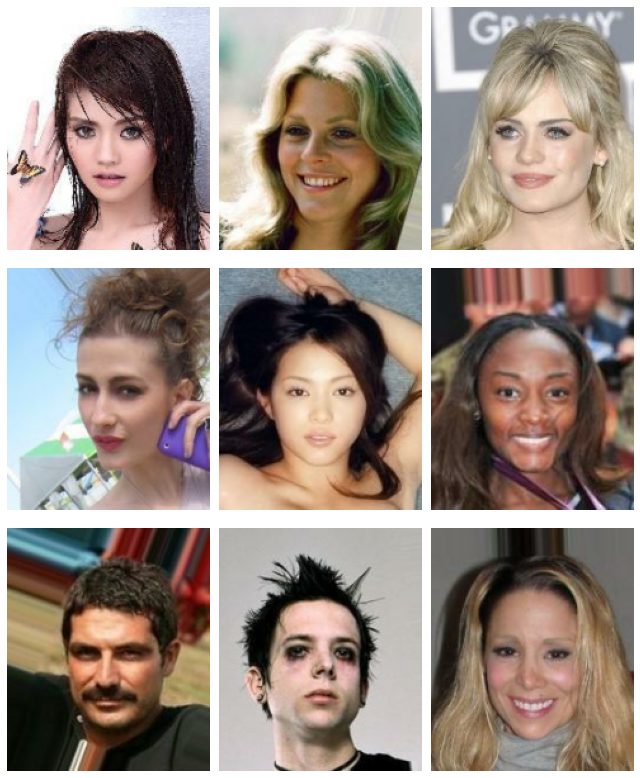

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 11))  #create a 3x3 grid of subplots with defined figure size

sample_images = [i for i in train_ds.take(1)][0].numpy()  #extract one batch of images from dataset

for i, ax in enumerate(axes.flatten()):  #iterate over each subplot
    ax.imshow((sample_images[i] * 0.5) + 0.5)  #denormalize and display image
    ax.axis(False)  #hide axis
    ax.grid(False)  #disable grid

plt.tight_layout()  #adjust layout to prevent overlap

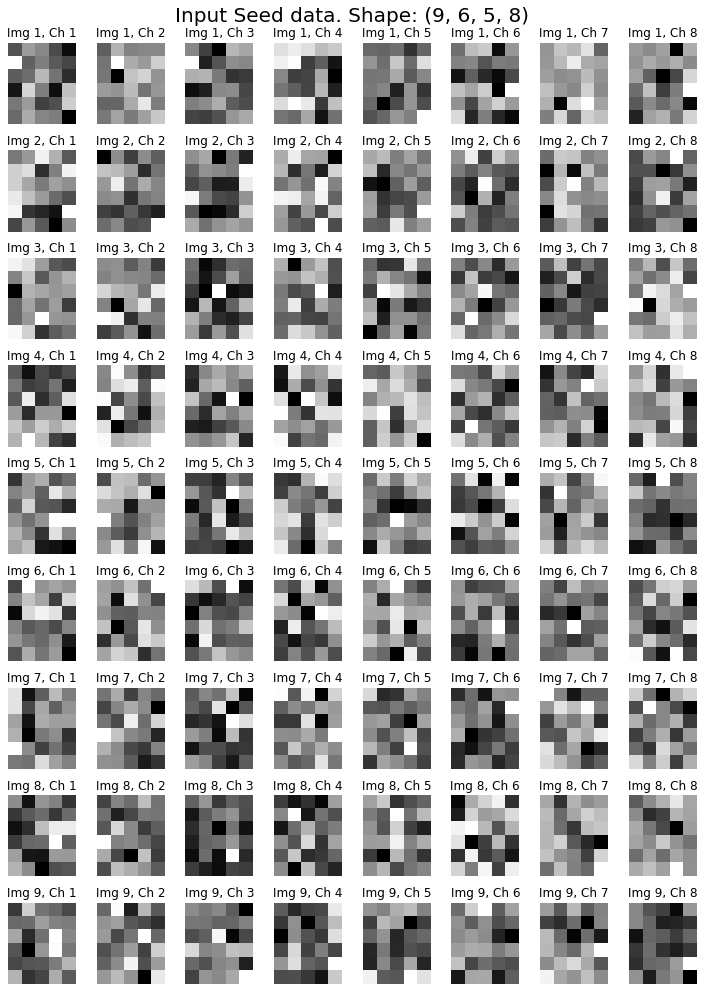

In [9]:
tf.random.set_seed(RANDOM_STATE)  #set random seed for reproducibility
seed_noise = tf.random.normal([PREDICT_COUNT, *GEN_NOISE_SHAPE], seed=RANDOM_STATE)  #generate random noise for generator input

fig, axes = plt.subplots(nrows=PREDICT_COUNT, ncols=GEN_NOISE_SHAPE[2], figsize=(10, 14))  #create subplots for visualization

for i in range(PREDICT_COUNT):  #iterate over each image
    for j in range(GEN_NOISE_SHAPE[2]):  #iterate over each channel
        axes[i][j].imshow(seed_noise[i, :, :, j], cmap='gray')  #display noise as grayscale image
        axes[i][j].axis(False)  #hide axis
        axes[i][j].grid(False)  #disable grid
        axes[i][j].set_title(f"Img {i + 1}, Ch {j + 1}")  #set title for each subplot
        
plt.suptitle(f'Input Seed data. Shape: {seed_noise.shape}', fontsize=20)  #set main title
plt.tight_layout()  

In [10]:
def generator_model():
    weight_init = TruncatedNormal(mean=0.0, stddev=0.02)  #initialize weights with truncated normal distribution

    input_layer = Input(shape=GEN_NOISE_SHAPE, name='Gen_Input')  #define input layer
    flatten = Flatten(name='Gen_Flatten')(input_layer)  #flatten input
    dense = Dense(6 * 5 * 512, use_bias=False, kernel_initializer=weight_init, 
                activation=LeakyReLU(GEN_RELU_ALPHA), name='Gen_Dense')(flatten)  #fully connected layer
    reshape = Reshape((6, 5, 512), name='Gen_Reshape')(dense)  #reshape to spatial dimensions
    sp_dropout_1 = SpatialDropout2D(0.2, name='Gen_SD_1')(reshape)  #apply spatial dropout

    conv_T_1 = Conv2DTranspose(512, (3, 3), padding='same', activation=LeakyReLU(GEN_RELU_ALPHA), use_bias=False,
                               kernel_initializer=weight_init, name='Gen_Conv_T_1')(sp_dropout_1)  #transpose conv layer
    conv_T_2 = Conv2DTranspose(256, (3, 3), padding='same', strides=(2, 2), use_bias=False,
                               kernel_initializer=weight_init, name='Gen_Conv_T_2')(conv_T_1)  #upsampling conv layer
    bn_1 = BatchNormalization(name='Gen_BN_1')(conv_T_2)  #batch normalization
    lr_1 = LeakyReLU(GEN_RELU_ALPHA, name='Gen_LR_1')(bn_1)  #leaky relu activation  

    conv_T_3 = Conv2DTranspose(128, (4, 4), padding='same', activation=LeakyReLU(GEN_RELU_ALPHA), use_bias=False, 
                               kernel_initializer=weight_init, name='Gen_Conv_T_3')(lr_1)  #another transpose conv layer
    conv_T_4 = Conv2DTranspose(64, (4, 4), padding='same', strides=(2, 2), use_bias=False, 
                               kernel_initializer=weight_init, name='Gen_Conv_T_4')(conv_T_3)  #upsampling
    bn_2 = BatchNormalization(name='Gen_BN_2')(conv_T_4)  #batch normalization
    lr_2 = LeakyReLU(GEN_RELU_ALPHA, name='Gen_LR_2')(bn_2)  #leaky relu activation
    sp_dropout_2 = SpatialDropout2D(0.2, name='Gen_SD_2')(lr_2)  #apply spatial dropout

    conv_T_5 = Conv2DTranspose(16, (5, 5), padding='same', strides=(2, 2), use_bias=False,
                               kernel_initializer=weight_init, name='Gen_Conv_T_5')(sp_dropout_2)  #upsampling conv layer
    bn_3 = BatchNormalization(name='Gen_BN_3')(conv_T_5)  #batch normalization
    lr_3 = LeakyReLU(GEN_RELU_ALPHA, name='Gen_LR_3')(bn_3)  #leaky relu activation
    sp_dropout_3 = SpatialDropout2D(0.15, name='Gen_SD_3')(lr_3)  #apply spatial dropout

    conv_T_6 = Conv2DTranspose(8, (6, 6), padding='same', strides=(2, 2), use_bias=False, 
                               kernel_initializer=weight_init, name='Gen_Conv_T_6')(sp_dropout_3)  #upsampling conv layer
    bn_4 = BatchNormalization(name='Gen_BN_4')(conv_T_6)  #batch normalization
    lr_4 = LeakyReLU(GEN_RELU_ALPHA, name='Gen_LR_4')(bn_4)  #leaky relu activation
    sp_dropout_4 = SpatialDropout2D(0.15, name='Gen_SD_4')(lr_4)  #apply spatial dropout

    conv_T_7 = Conv2DTranspose(8, (7, 7), padding='same', activation=LeakyReLU(GEN_RELU_ALPHA), use_bias=False,
                               kernel_initializer=weight_init, strides=(2, 2), name='Gen_Conv_T_7')(sp_dropout_4)  #upsampling
    conv_T_8 = Conv2DTranspose(3, (5, 5), padding='same', kernel_initializer=weight_init, use_bias=False,
                               activation='tanh', name='Gen_Conv_T_8')(conv_T_7)  #final conv layer with tanh activation

    return Model(inputs=input_layer, outputs=conv_T_8, name='Generator')  #return generator model
    
generator = generator_model()  #create generator instance
generator.summary()  #print model summary


Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Gen_Input (InputLayer)       [(None, 6, 5, 8)]         0         
_________________________________________________________________
Gen_Flatten (Flatten)        (None, 240)               0         
_________________________________________________________________
Gen_Dense (Dense)            (None, 15360)             3686400   
_________________________________________________________________
Gen_Reshape (Reshape)        (None, 6, 5, 512)         0         
_________________________________________________________________
Gen_SD_1 (SpatialDropout2D)  (None, 6, 5, 512)         0         
_________________________________________________________________
Gen_Conv_T_1 (Conv2DTranspos (None, 6, 5, 512)         2359296   
_________________________________________________________________
Gen_Conv_T_2 (Conv2DTranspos (None, 12, 10, 256)       11

In [12]:
def discriminator_model():
    input_layer = Input(shape = (*IMAGE_SIZE, 3), name = 'Disc_Input') #defines input layer with specified image size

    conv_1 = Conv2D(32, (4, 4), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_1')(input_layer) #first convolutional layer with 32 filters
    max_pool_1 = MaxPool2D(2, name = 'Disc_MP_1')(conv_1) #max pooling to reduce spatial dimensions
    conv_2 = Conv2D(64, (4, 4), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_2')(max_pool_1) #second convolutional layer with 64 filters
    max_pool_2 = MaxPool2D(2, name = 'Disc_MP_2')(conv_2) #max pooling to further reduce spatial dimensions
    global_pool_1 = GlobalAvgPool2D(name = 'Disc_GAP_1')(max_pool_2) #global average pooling for feature extraction

    sp_dropout_1 = SpatialDropout2D(0.2, name = 'Disc_SD_1')(max_pool_2) #spatial dropout to prevent overfitting
    conv_3 = Conv2D(128, (3, 3), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_3')(sp_dropout_1) #third convolutional layer with 128 filters
    max_pool_3 = MaxPool2D(2, name = 'Disc_MP_3')(conv_3) #max pooling to downsample
    conv_4 = Conv2D(256, (3, 3), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_4')(max_pool_3) #fourth convolutional layer with 256 filters
    max_pool_4 = MaxPool2D(2, name = 'Disc_MP_4')(conv_4) #max pooling to further reduce size
    global_pool_2 = GlobalAvgPool2D(name = 'Disc_GAP_2')(max_pool_4) #global average pooling for feature extraction

    sp_dropout_2 = SpatialDropout2D(0.2, name = 'Disc_SD_2')(max_pool_4) #another spatial dropout layer
    conv_5 = Conv2D(512, (2, 2), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_5')(sp_dropout_2) #fifth convolutional layer with 512 filters
    max_pool_5 = MaxPool2D(2, name = 'Disc_MP_5')(conv_5) #max pooling for final downsampling
    global_pool_3 = GlobalAvgPool2D(name = 'Disc_GAP_3')(max_pool_5) #global average pooling for feature extraction

    concat = Concatenate(name = 'Disc_Concat')([global_pool_1, global_pool_2, global_pool_3]) #concatenating pooled features
    dropout = Dropout(0.2, name = 'Disc_Dropout')(concat) #dropout to reduce overfitting
    dense_1 = Dense(32, activation = LeakyReLU(DISC_RELU_ALPHA), name = 'Disc_Dense_1')(dropout) #fully connected layer with 32 neurons
    dense_2 = Dense(1, name = 'Disc_Dense_2')(dense_1) #output layer for classification

    return Model(inputs = input_layer, outputs = dense_2, name = 'Discriminator') #returns the discriminator model

discriminator = discriminator_model() #initializing the discriminator model
discriminator.summary() #printing the model summary

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Disc_Input (InputLayer)         [(None, 192, 160, 3) 0                                            
__________________________________________________________________________________________________
Disc_Conv_1 (Conv2D)            (None, 192, 160, 32) 1568        Disc_Input[0][0]                 
__________________________________________________________________________________________________
Disc_MP_1 (MaxPooling2D)        (None, 96, 80, 32)   0           Disc_Conv_1[0][0]                
__________________________________________________________________________________________________
Disc_Conv_2 (Conv2D)            (None, 96, 80, 64)   32832       Disc_MP_1[0][0]                  
______________________________________________________________________________________

In [14]:
cross_entropy = BinaryCrossentropy(from_logits = True) #binary cross-entropy loss for classification
gen_mean_loss = Mean(name = "Generator mean loss") #mean loss tracker for generator
disc_mean_loss = Mean(name = "Discriminator mean loss") #mean loss tracker for discriminator
generator_optimizer = Adam(GEN_LR, beta_1 = GEN_BETA_1) #Adam optimizer for generator with specified learning rate and beta_1
discriminator_optimizer = Adam(DISC_LR, beta_1 = DISC_BETA_1) #Adam optimizer for discriminator with specified learning rate and beta_1

In [15]:
checkpoint_dir = './ckpt' #directory to save model checkpoints

checkpoint = Checkpoint( 
    step = tf.Variable(1), #variable to track training step
    generator_optimizer = generator_optimizer, #saving generator optimizer state
    discriminator_optimizer = discriminator_optimizer, #saving discriminator optimizer state
    generator = generator, #saving generator model
    discriminator = discriminator) #saving discriminator model

ckpt_manager = CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 5) #manages checkpoints, keeping the latest 5

EPOCH_START = 1 #default start epoch
if RETRAIN: #if retraining from a checkpoint
    checkpoint.restore(ckpt_manager.latest_checkpoint) #restore latest checkpoint
    EPOCH_START = checkpoint.step.numpy() #update starting epoch

print(f"Starting training from Epoch {EPOCH_START}") 

Starting training from Epoch 151


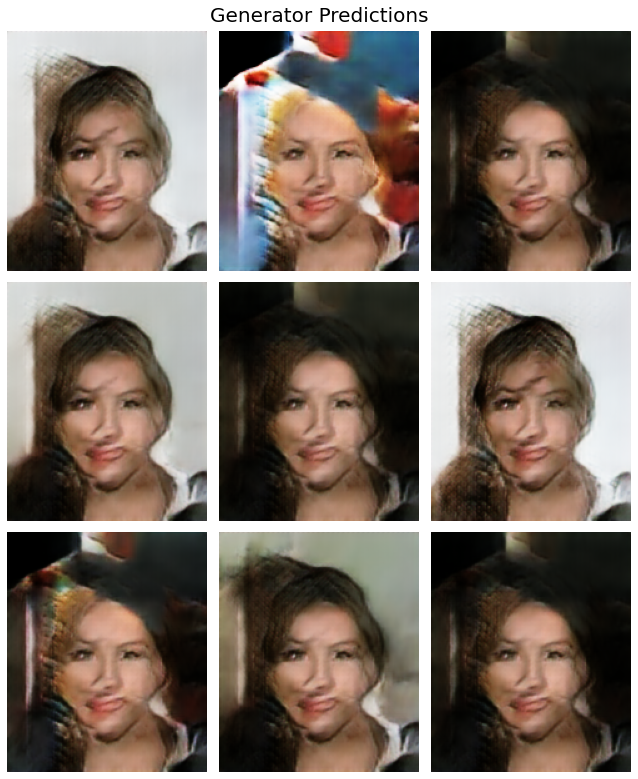

In [16]:
def generate_images(seed, save = False, epoch = None): #function to generate and optionally save images
    pred = generator(seed, training = False) #generate images using the generator model

    fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (9, 11)) #create a 3x3 grid for displaying images

    for i, ax in enumerate(axes.flatten()): #iterate over each subplot
        ax.imshow((pred[i] * 0.5) + 0.5) #scale images from [-1,1] to [0,1] for proper display
        ax.axis(False) #remove axis
        ax.grid(False) #remove grid

    plt.suptitle('Generator Predictions', fontsize = 20) #set the title for the figure
    
    plt.tight_layout() #adjust layout for better spacing

    if save: #if saving is enabled
        plt.savefig(f'Pred_Epoch_{epoch:04d}.png', dpi = PLOTS_DPI, facecolor = 'white',  
                transparent = False, bbox_inches = 'tight') 
        plt.close() #close the plot to free memory
    
generate_images(seed_noise) 

In [17]:
discriminator(generator(seed_noise, training = False), training = False).numpy()

array([[ 0.0133222 ],
       [ 0.0088398 ],
       [-0.0001304 ],
       [-0.00061493],
       [ 0.00175689],
       [ 0.01352044],
       [-0.00155599],
       [ 0.00682388],
       [-0.00073949]], dtype=float32)

In [18]:
def discriminator_loss(real_output, fake_output): #calculates the loss for the discriminator
    pos_labels = tf.ones_like(real_output) - (tf.random.uniform(real_output.shape) * DISC_LABEL_SMOOTHING) #apply label smoothing to real labels
    neg_labels = tf.zeros_like(fake_output) + (tf.random.uniform(fake_output.shape) * DISC_LABEL_SMOOTHING) #apply label smoothing to fake labels
    real_loss = cross_entropy(pos_labels, real_output) #compute cross-entropy loss for real images
    fake_loss = cross_entropy(neg_labels, fake_output) #compute cross-entropy loss for fake images
    total_loss = real_loss + fake_loss #sum both losses to get total discriminator loss
    return total_loss #return total loss

def generator_loss(fake_output): #calculates the loss for the generator
    return cross_entropy(tf.ones_like(fake_output), fake_output) #compute cross-entropy loss for generator (fooling the discriminator)

In [19]:
@tf.function
def train_step(images): #performs a single training step for both generator and discriminator
    noise = tf.random.normal([BATCH_SIZE, *GEN_NOISE_SHAPE]) #generate random noise for the generator

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #track gradients for both generator and discriminator
        generated_images = generator(noise, training = True) #generate images from noise

        real_output = discriminator(images, training = True) #get discriminator output for real images
        fake_output = discriminator(generated_images, training = True) #get discriminator output for fake images

        gen_loss = generator_loss(fake_output) #compute generator loss
        disc_loss = discriminator_loss(real_output, fake_output) #compute discriminator loss

    gen_mean_loss(gen_loss) 
    disc_mean_loss(disc_loss) 

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) #compute generator gradients
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) #compute discriminator gradients

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) #apply generator gradients
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) #apply discriminator gradients

In [20]:
gen_losses = [] #store generator loss per epoch
disc_losses = [] #store discriminator loss per epoch

def train(dataset, epochs): #train the GAN model for the given number of epochs
    for epoch in range(epochs): #loop over epochs
        start = time.time() #record start time of epoch

        gen_mean_loss.reset_states() #reset generator loss state
        disc_mean_loss.reset_states() #reset discriminator loss state
        
        print(f"\nTraining Epoch {epoch + EPOCH_START}\n") #display current epoch
        
        for batch_ind, image_batch in enumerate(dataset): #loop over batches in dataset
            train_step(image_batch) #perform training step

            if (batch_ind + 1) % 10 == 0: #print progress every 10 batches
                print(". ", end = '')
            if (batch_ind + 1) % 250 == 0: #print batch count every 250 batches
                print(f"{batch_ind + 1}")
        
        checkpoint.step.assign_add(1) #increment checkpoint step counter

        display.clear_output(wait = True) #clear output for cleaner logs
        
        generate_images(seed_noise, True, epoch + EPOCH_START) #generate and save images
        
        if (epoch + EPOCH_START) % 5 == 0: #save model checkpoint every 5 epochs
            ckpt_manager.save()
            
        gen_losses.append(gen_mean_loss.result()) #store generator loss
        disc_losses.append(disc_mean_loss.result()) #store discriminator loss

        print(f"\nEpoch: {epoch + EPOCH_START}\n")


In [ ]:
train(train_ds, EPOCHS)

print(f'Final Generator Loss: {gen_mean_loss.result()}')
print(f'Final Discriminator Loss: {disc_mean_loss.result()}')


Training Epoch 151

. . . . . . . . . . . . . . . . . . . . . . . . . 250
. . . . . . . . . . . . . . . . . . . . . . . . . 500
. . . . . . . . . . . . . . . . . . . . . . . . . 750
. . . . . . . . . . . . . . . . . . . . . . . . . 1000
. . . . . . . . . . . . . . . . . . . . . . . . . 1250
. . . . . . . . . . . . . . . . . . . . . . . . . 1500
. . . . . . . . . . . . . . . . . . . . . . . . . 1750
. . . . . . . . . . . . . . . . . . . . . . . . . 2000
. . . . . . . . . . . . . . . . . . . . . . . . . 2250
. . . . . . . . . . . . . . . . . . . . . . . . . 2500
. . . . . . . . . . . . . . . . . . . . . . . . . 2750
. . . . . . . . . . . . . . . . . . . . . . . . . 3000
. . . . . . . . . . . . . . 

In [ ]:
generate_images(seed_noise)

In [ ]:
epoch_range = range(EPOCH_START, EPOCHS + EPOCH_START)
plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, gen_losses)
plt.xticks(epoch_range)
plt.title('Generator loss', fontsize = 18)

plt.subplot(1, 2, 2)
plt.plot(epoch_range, disc_losses)
plt.xticks(epoch_range)
plt.title('Discriminator loss', fontsize = 18)

plt.suptitle('Loss per epoch', fontsize = 24)
plt.show()

In [ ]:
generator.save("generator")
discriminator.save("discriminator")